# Initialize neccessary packages

- Begin by importing all necessary packages for the analysis of the model

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
#from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('large')
# set these constants to incluse the effects of: 
# ICU facilities becoming overwhelmed
ICU_OVERWHELM = True
# R_t being modified due to number of deaths:
DEATH_REACTIVE_R_T = True

# definition of my equations- vaccination model

- define erquations for the time evolution of the compartments that are involved in the model.

In [80]:


# Zero vaccination
def dV0_dt(V0, I, R_t, t_inf,r1):
    return -(R_t /t_inf) * I * V0 - r1

# First Vaccination
def dV1_dt(V0,V1, I, R_t, t_inf, r1,r2,e1):
    return r1 - r2 - (1-e1)*V1*I*(R_t/t_inf)


# Second Vaccination
def dV2_dt(V1,V2,I,R_t,t_inf,r2,e1,e2):
    return r2 - e2*V2 - (1-e2)*(R_t/t_inf)*V2*I


# Infected
def dI_dt(V0,V1,V2,I,R_t,t_inf,e1,e2):
    return (R_t/t_inf)*I*(V0+(1-e1)*V1+(1-e2)*V2)-(I/t_inf)

# Hospitalized 
def dH_dt(I, C, H, t_inf,t_crit, t_hosp,m, f):
    return ((1 - m) * (I / t_inf)) + ((1 - f) * C / t_crit) - (H / t_hosp)

# Critical
def dC_dt(H, C, t_hosp, t_crit, k):
    return (k * H / t_hosp) - (C/t_crit)
    # return (frac_crit * H / t_hosp) - (1-frac_fatal)*(C/t_crit) - frac_fatal*(C/t_crit)
    # i.e.  = (term gained from Hospitalised) - (term lost to Hospitalised) - (term lost to Deaths)
    #       = (term gained from H) - (terms lost to both H and D)

# Recovered Naturally
def dR1_dt(V2,I, H, t_inf, t_hosp,m, k):
    return  (m * I / t_inf) + (1 - k) * (H / t_hosp)

# Recovered from vaccination
def dR2_dt(V2,e2):
    return e2*V2

# Deaths
def dD_dt(C, t_crit, f):
    return f * (C/t_crit)



# this function is a saturating look-up table

#def find_idx_nearest(array, value):
   # array = np.asarray(array)
   # idx = (np.abs(array - value)).argmin()
    #return idx # array[idx], idx

def V0V1V2IR_HCD_model(t, y, R_t, t_inf=6.1, t_hosp=4, t_crit=10, m=0.96, k=0.2,
                       f=0.2, r1 =0 ,r2= 0, e1=0.8, e2=0.9):
    """
    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Time-varying reproductive number
    :param t_inc: Average incubation period. 
    :param t_inf: Average infectious period. 
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical.
    :param t_crit: Average time a patient is in a critical state (either recovers or dies).
    :param m: Fraction of infections that are asymptomatic or mild.      
    :param k: Fraction of severe cases that turn critical.                      
    :param f: Fraction of critical cases that are fatal.
    :param r1: Vaccination rate applied to V0.
    :param r2: Vaccination rate applied to V1.
    :param e1: efficacy rate of the first dose.
    :param e2: efficacy rate of the second dose.
    :return:
    """
    
    # Evaluate R_t if it is a function, otherwise use it as is
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t

    V0, V1, V2, I, R1, R2, H, C, D = y


    # Account for ICU overload by modifying the fatality ratio
    
   
      
      

    V0_out = dV0_dt(V0, I, reprod, t_inf,r1)
    V1_out = dV1_dt(V0,V1, I, reprod, t_inf, r1,r2,e1)
    V2_out = dV2_dt(V1,V2,I,reprod,t_inf,r2,e1,e2)
    I_out = dI_dt(V0,V1,V2,I,reprod,t_inf,e1,e2)
    R1_out = dR1_dt(V2,I, H, t_inf, t_hosp,m, k)
    R2_out = dR2_dt(V2,e2)
    H_out = dH_dt(I, C, H, t_inf,t_crit, t_hosp,m, f)
    C_out = dC_dt(H, C, t_hosp, t_crit, k)
    D_out = dD_dt(C, t_crit, f)
    return [V0_out, V1_out, V2_out, I_out, R1_out, R2_out, H_out, C_out, D_out]

## Plotting the model evolution without vaccination

In [125]:
def plot_model_evolution0(solution, title=''):
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = solution.y
    
    cases = infected + rec2 + hosp + crit + death

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle(title)
    
    ax1.plot(z_vaccination, color='blue', label='Zero vaccination');
    ax1.plot(f_vaccination, color='black', label='first dose');
    ax1.plot(s_vaccination, color='yellow', label = 'second dose');
    ax1.plot(infected, color='red', label='Infected');
    ax1.plot(rec1,color='magenta', label='Recovered without vaccination');
    ax1.plot(rec2, color='green', label='Recovered due to vaccination');
    ax1.plot(hosp, color='purple', label='Hospitalised');
    ax1.plot(crit, color='brown', label='Critical');
    ax1.plot(death, color='cyan', label='death');
    
    ax1.set_xlabel("Days", fontsize=20);
    ax1.set_ylabel("Fraction of population", fontsize=20);
    ax1.legend(loc='best');
    
    ax2.plot(cases, color='red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=20);
    ax2.set_ylabel("Fraction of population (Cases)", fontsize=20, color='red');
    
    ax3 = ax2.twinx()
    ax3.plot(death, color='cyan', label='death');    
    ax3.set_xlabel("Days", fontsize=20);
    ax3.set_ylabel("Fraction of population (Fatalities)", fontsize=20, color='cyan');
    
    #================================================================
    

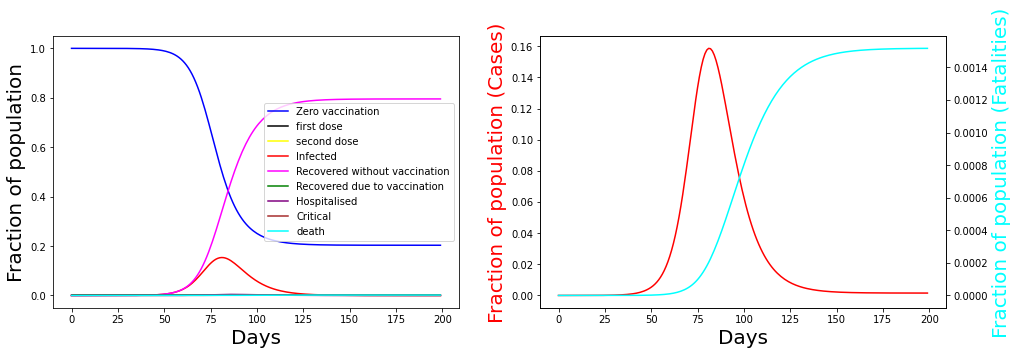

In [126]:
N = 6*pow(10,7)  # Population size
n_infected = 100
max_days = 200

# The numbers correspond to the number of people in each of the SEIRHCD compartments
initial_state1 = [((N - n_infected)/ N), 0, 0, n_infected / N, 0, 0, 0, 0, 0]

R_0 = 2
t_inf = 6.1
t_hosp = 4
t_crit = 10
m=0.96
k=0.2
f=0.2
r1=0
r2=0
e1=0.45
e2=0.9


args = (R_0, t_inf, t_hosp, t_crit, m, k, f,r1,r2,e1,e2)

sol = solve_ivp(V0V1V2IR_HCD_model, [0, max_days], initial_state1, args=args, t_eval=np.arange(max_days))

plot_model_evolution0(sol)

## Plotting the attack rate of the disease against different values of $\mathbf{R_0}$

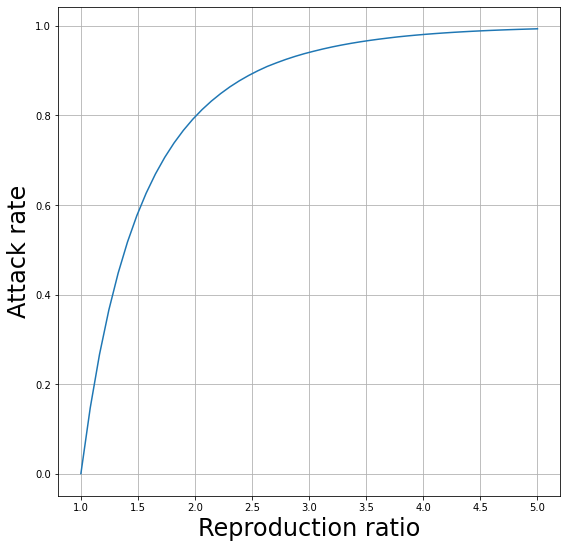

In [87]:
def plot_model_evolution1(solution, title='V0V1V2IRHCD model without vaccination'):
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = solution.y
    
    cases = infected + rec2 + hosp + crit + death
    all_persons = [round(val*6*10**7) for val in z_vaccination]
    return min(all_persons)
    
    #====================================================================================================
    
max_days1 = 2500

initial_state1 = [(N - n_infected)/N, 0, 0, n_infected/N, 0, 0, 0, 0, 0]
val_R_0= np.linspace(1,5,50)
val_max_I = []
args = (R_0, t_inf, t_hosp, t_crit, m, k, f,r1,r2,e1,e2)

sol = solve_ivp(V0V1V2IR_HCD_model, [0, max_days1], initial_state1, args=args, t_eval=np.arange(max_days1))
for R_0 in val_R_0:
    args = (R_0, t_inf, t_hosp, t_crit, m, k, f,r1,r2,e1,e2)
    sol = solve_ivp(V0V1V2IR_HCD_model, [0, max_days1], initial_state1, args=args, t_eval=np.arange(max_days1))
    max_infected = plot_model_evolution1(sol, 'V0V1V2IRHCD model without vaccination')
    val_max_I.append(max_infected)
val_max_I=np.array(val_max_I).transpose()
val_max_I=((N-val_max_I)/N)

#=======================================================================================


plt.figure(figsize=(9,9))
plt.plot(val_R_0,val_max_I)
plt.xlabel('Reproduction ratio',fontsize=24)
plt.ylabel('Attack rate',fontsize=24)
#plt.title('Plot of attack rate against different values of reproduction ratio')
plt.grid(True)
plt.show()


# define my model to be plotted with different vaccination schedules

- define a model for the plots of time evolution compartments. The plot should show how each compartmentt changes with respect to time. I will also plot the fatality rate and the plot of cases with respect to time. 

In [113]:
def plot_model_evolution(solution, title='V0V1V2IRHCD model without vaccination'):
    
    """The function plots the evolution of compartments in when there is no vaccination"""
    
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = solution.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    plt.rcParams.update({'font.size': 18})

    fig, (ax2) = plt.subplots(1, 1, figsize=(30,30))
    fig.suptitle(title)
    plt.figure(figsize=(12,12))
    
    
    
    ax2.plot(cases, color='red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=16);
    ax2.set_ylabel("Fraction of population (Cases)", fontsize=16, color='red');
    
    ax3 = ax2.twinx()
    ax3.plot(death, color='cyan', label='death');    
    ax3.set_xlabel("Days", fontsize=16);
    ax3.set_ylabel("Fraction of population (Fatalities)", fontsize=16, color='cyan');
  #======================================================================================================

def compare_evolution(sol1,sol2,sol3,sol4,sol5,sol6,sol7,
                      title=['Evolution of fatalities with different rates of vaccination']):
    
    """The function plots the fatality rate given different vaccination rates. """
    
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol1.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1

    fig, (ax5) = plt.subplots(1, 1, figsize=(16,5))
    fig.suptitle(title[0])
    plt.ylim(0.00125, 0.00158)
    
    
   
    ax5.plot(death, color='darkred', linewidth=2, alpha=1, label='$r_{1p}=0, \quad r_{2p}=0$');    
    ax5.set_xlabel("Days", fontsize=18);
    ax5.set_ylabel("Fraction of population (Fatalities)", fontsize=18, color='cyan');
    ax5.grid(color='cyan', linestyle='-', linewidth=0.25, alpha=0.9);
    ax5.legend(loc='best');
    #plt.plot(x, x+1, color="green", linewidth=2,alpha=0.3)
   #===============================================================    
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol2.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1

    ax5.plot(death, color='red', linewidth=2, alpha=1, label='$r_{1p}=1,\quad r_{2p}=0$');    
    ax5.set_xlabel("Days", fontsize=18);
    ax5.set_ylabel("Fraction of population (Fatalities)", fontsize=18, color='green');
    ax5.legend(loc='best');
    #=================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol3.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax5.plot(death, color='red', linewidth=2, alpha=0.68754, label='$r_{1p}=0.95, \quad r_{2p}=0.05$');    
    ax5.set_xlabel("Days", fontsize=18);
    ax5.set_ylabel("Fraction of population (Fatalities)", fontsize=18, color='green');
    ax5.legend(loc='best');
    #=================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol4.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax5.plot(death, color='red', linewidth=2, alpha=0.48571429, label='$r_{1p}=0.8,\quad  r_{2p}=0.2$');    
    ax5.set_xlabel("Days", fontsize=18);
    ax5.set_ylabel("Fraction of population (Fatalities)", fontsize=18, color='green');
    ax5.legend(loc='best');
    #=====================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol5.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax5.plot(death, color='red', linewidth=2, alpha=0.35714286, label='$r_{1p}=0.7,\quad r_{2p}=0.3$');    
    ax5.set_xlabel("Days", fontsize=18);
    ax5.set_ylabel("Fraction of population (Fatalities)", fontsize=18, color='green');
    ax5.legend(loc='best');
    #======================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol6.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax5.plot(death, color='red', linewidth=2, alpha=0.22857143, label='$r_{1p}=0.6,\quad r_{2p}=0.4$');    
    ax5.set_xlabel("Days", fontsize=18);
    ax5.set_ylabel("Fraction of population (Fatalities)", fontsize=18, color='green');
    ax5.legend(loc='best');
    #======================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol7.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax5.plot(death, color='red', linewidth=2, alpha=0.18, label='$r_{1p}= 0.5,\quad r_{2p}=0.5$');    
    ax5.set_xlabel("Days", fontsize=18);
    ax5.set_ylabel("Fraction of population (Fatalities)", fontsize=18, color='green');
    ax5.legend(loc='best');
    #=======================================================================
    #=======================================================================
    
    

#===========================================================================================================

def compare_evolution_with_diff_R0(sol11,sol21,sol31,sol41,sol51,sol61,sol71,
                      title=['Evolution of fatalities with different values of reproduction ratio']):
    
    """The function plots different fatality rates given different values of R_0"""
    
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol11.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1

    fig, (ax6) = plt.subplots(1, 1, figsize=(16,5))
    fig.suptitle(title[0])
    plt.ylim(0.0011, 0.0019)
    
    
   
    ax6.plot(death, color='red', linewidth=2, alpha=0.1, label='$R_0=2$');    
    ax6.set_xlabel("Days", fontsize=16);
    ax6.set_ylabel("Fraction of population (Fatalities)", fontsize=16, color='cyan');
    ax6.grid(color='cyan', linestyle='-', linewidth=0.25, alpha=0.9);
    ax6.legend(loc='best');
    #plt.plot(x, x+1, color="green", linewidth=2,alpha=0.3)
   #===============================================================    
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol21.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1

    ax6.plot(death, color='red', linewidth=2, alpha=0.22857143, label='$R_0=2.5$');    
    ax6.set_xlabel("Days", fontsize=16);
    ax6.set_ylabel("Fraction of population (Fatalities)", fontsize=16, color='green');
    ax6.legend(loc='best');
    #=================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol31.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax6.plot(death, color='red', linewidth=2, alpha=0.35714286, label='$R_0=3$');    
    ax6.set_xlabel("Days", fontsize=16);
    ax6.set_ylabel("Fraction of population (Fatalities)", fontsize=16, color='green');
    ax6.legend(loc='best');
    #=================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol41.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax6.plot(death, color='red', linewidth=2, alpha=0.48571429, label='$R_0=3.5$');    
    ax6.set_xlabel("Days", fontsize=16);
    ax6.set_ylabel("Fraction of population (Fatalities)", fontsize=16, color='green');
    ax6.legend(loc='best');
    #=====================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol51.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax6.plot(death, color='red', linewidth=2, alpha=0.68754, label='$R_0=4$');    
    ax6.set_xlabel("Days", fontsize=16);
    ax6.set_ylabel("Fraction of population (Fatalities)", fontsize=16, color='green');
    ax6.legend(loc='best');
    #======================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol61.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax6.plot(death, color='red', linewidth=2, alpha=1, label='$R_0=4.5$');    
    ax6.set_xlabel("Days", fontsize=16);
    ax6.set_ylabel("Fraction of population (Fatalities)", fontsize=16, color='green');
    ax6.legend(loc='best');
    #======================================================================
    z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = sol71.y
    
    cases = infected + rec2 + hosp + crit + death
    total_recovered = rec2 + rec1
    
    ax6.plot(death, color='darkred', linewidth=2, alpha=1, label='$R_0=5$');    
    ax6.set_xlabel("Days", fontsize=16);
    ax6.set_ylabel("Fraction of population (Fatalities)", fontsize=16, color='green');
    ax6.legend(loc='best');
    
#===========================================================================================================
N = 6*pow(10,7)  # Population size
n_infected = 100 #people who are infected on the day we simulate the model
number_of_days = 200 #the duration for which our simulations takes
initial_state = [((N - n_infected)/ N)-0.3, 0.3, 0, n_infected / N, 0, 0, 0, 0, 0] #initial status of compartments
R_0 = 2.5 #base case for R_0
t_inf = 6.1
t_hosp = 4
t_crit = 10
m=0.96
k=0.2
f=0.2
e1=0.45
e2=0.9
#possible schedules for dose 1 and dose 2 (r1 and r2)
list_of_r1=[0, (100000/60000000), (95000/60000000), (80000/60000000),
           (70000/60000000), (60000/60000000), (50000/60000000)]
list_of_r2=[0, (0/60000000), (5000/60000000), (20000/60000000),
           (30000/60000000), (40000/60000000), (50000/60000000)]
#=====================================================================
diff_values_R0=[ 2, 2.5, 3, 3.5,  4, 4.5, 5] #Different values of R_0
#=====================================================================

#different values of e1
diff_e1=[0.45, 0.64, 0.7, 0.8, 0.1] #different values of e1 for the initial simulations
DIFF_e1=np.arange(0.1,0.85,0.05) #different values of e1 for further simulations

diffe2=[0.45,0.6,0.7,0.8,0.9] #different values of e2 for the initial simulations
DIFFe2=np.arange(0.5,0.95,0.05) # different values of e2 for further simulations

In [114]:
len(DIFF_e1)
DIFFe2[8]

0.9000000000000004

In [115]:
soln = []
for i in range(7):
      args1 = (R_0, t_inf, t_hosp, t_crit, m, k, f,list_of_r1[i],list_of_r2[i],e1,e2)
      soln.append(solve_ivp(V0V1V2IR_HCD_model, [0, number_of_days], initial_state, args=args1, t_eval=np.arange(number_of_days)))

In [116]:
arg={} #initialize different input values of the  arguements based on r1 and r2
sol={} #initialize different solutions of the given input
for v in range(1,8):
    arg[v]=[] 
    sol[v]=[]
    for u in range(5):
        arg[v].append((R_0, t_inf, t_hosp, t_crit, m, k, f,list_of_r1[v-1],list_of_r2[v-1],diff_e1[u],e2))
        sol[v].append(solve_ivp(V0V1V2IR_HCD_model, [0, number_of_days], initial_state, args=arg[v][u], t_eval=np.arange(number_of_days)))

## Plotting different vaccination schedules

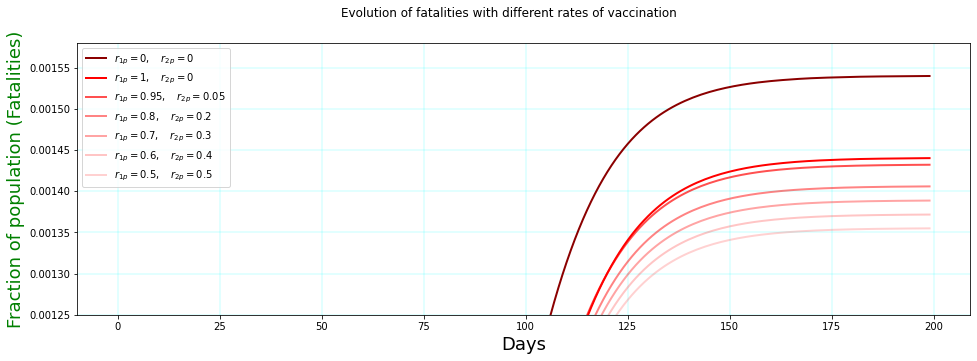

In [117]:
compare_evolution(sol[1][0],sol[2][0],sol[3][0],sol[4][0],sol[5][0],sol[6][0],sol[7][0],title=['Evolution of fatalities with different rates of vaccination'])

##### The death is reduced when the vaccines are equally shared between the first dose and second dose. 

## Plotting percentage differences of other vaccination schedules from the optimal solution

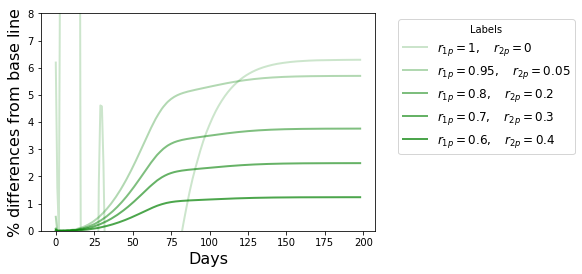

In [76]:
"""The plot shows percentage differences of other vaccination schedules from the optimal solution"""

sd2=((sol[2][0].y[8][1:]-sol[7][0].y[8][1:])/sol[7][0].y[8][1:])*100
sd3=((sol[3][0].y[8][1:]-sol[7][0].y[8][1:])/sol[7][0].y[8][1:])*100
sd4=((sol[4][0].y[8][1:]-sol[7][0].y[8][1:])/sol[7][0].y[8][1:])*100
sd5=((sol[5][0].y[8][1:]-sol[7][0].y[8][1:])/sol[7][0].y[8][1:])*100
sd6=((sol[6][0].y[8][1:]-sol[7][0].y[8][1:])/sol[7][0].y[8][1:])*100

G1,=plt.plot(sd2,label='$r_{1p}=1,\quad r_{2p}=0$',linewidth=2,alpha=0.2, color='green')
G2,=plt.plot(sd3,label='$r_{1p}=0.95,\quadr_{2p}=0.05$',linewidth=2,alpha=0.3, color='green')
G3,=plt.plot(sd4, label='$r_{1p}=0.8,\quadr_{2p}=0.2$', linewidth=2,alpha=0.5, color='green')
G4,=plt.plot(sd5, label='$r_{1p}=0.7,\quadr_{2p}=0.3$', linewidth=2,alpha=0.6, color='green')
G5,=plt.plot(sd6, label='$r_{1p}=0.6,\quadr_{2p}=0.4$', linewidth=2,alpha=0.7, color='green')

plt.ylim(0.00, 8)

plt.xlabel('Days',fontsize=16)
plt.ylabel('$\%$ differences from base line',fontsize=16)
#plt.title('percentage differences vs time, baseline :$r_1=0.5,r_2=0.5$')
#plt.legend(loc='best')
plt.legend(handles=[G1,G2,G3,G4,G5], title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
#plt.grid(True)
plt.show()
#np.isfinite((sd2)).all()



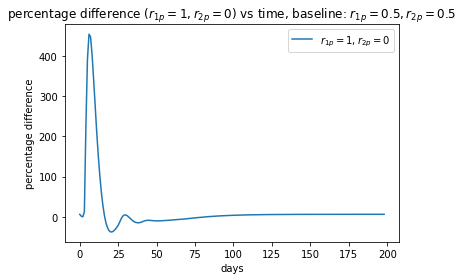

In [28]:


plt.plot(((sol[2][0].y[8][1:]-sol[7][0].y[8][1:])/sol[7][0].y[8][1:])*100, label='$r_{1p}=1,r_{2p}=0$')
plt.ylabel('percentage difference')
plt.xlabel('days')
plt.title('percentage difference $(r_{1p}=1,r_{2p}=0)$ vs time, baseline: $r_{1p}=0.5,r_{2p}=0.5$')
plt.legend(loc='best')
plt.show()


# The optimal solution using different values of $\mathbf{R_0}$

In [29]:
for v in range(1,8):
    arg[v].append((diff_values_R0[v-1], t_inf, t_hosp, t_crit, m, k, f,list_of_r1[6],list_of_r2[6],e1,e2))
    sol[v].append(solve_ivp(V0V1V2IR_HCD_model, [0, number_of_days], initial_state, args=arg[v][5], t_eval=np.arange(number_of_days)))

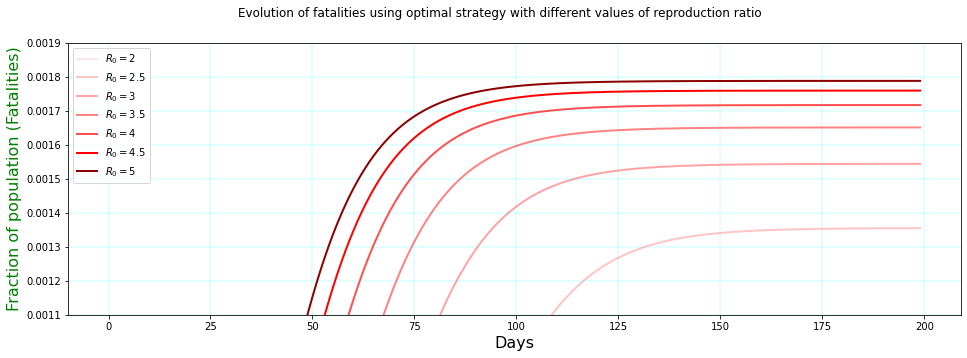

In [30]:
compare_evolution_with_diff_R0(sol[1][5],sol[2][5],sol[3][5],sol[4][5],sol[5][5],sol[6][5],sol[7][5],
                      title=['Evolution of fatalities using optimal strategy with different values of reproduction ratio'])

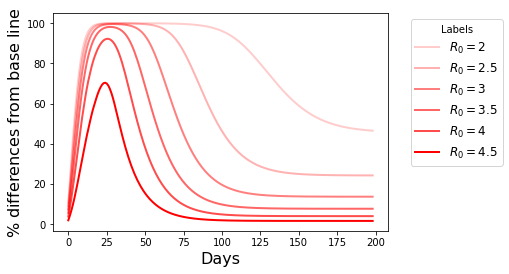

0

In [77]:
"""Calculate the percentage differences of different R_0 from the baseline of R_0=5 and observe 
the percentage by which the disease would have been decreased with smaller values of R_0"""


Rsd2=((sol[7][5].y[8][1:]-sol[1][5].y[8][1:])/sol[7][5].y[8][1:])*100
Rsd3=((sol[7][5].y[8][1:]-sol[2][5].y[8][1:])/sol[7][5].y[8][1:])*100
Rsd4=((sol[7][5].y[8][1:]-sol[3][5].y[8][1:])/sol[7][5].y[8][1:])*100
Rsd5=((sol[7][5].y[8][1:]-sol[4][5].y[8][1:])/sol[7][5].y[8][1:])*100
Rsd6=((sol[7][5].y[8][1:]-sol[5][5].y[8][1:])/sol[7][5].y[8][1:])*100
Rsd7=((sol[7][5].y[8][1:]-sol[6][5].y[8][1:])/sol[7][5].y[8][1:])*100
N1,=plt.plot(Rsd2,label='$R_0=2$',linewidth=2,alpha=0.2, color='red')
N2,=plt.plot(Rsd3,label='$R_0=2.5$',linewidth=2,alpha=0.3, color='red')
N3,=plt.plot(Rsd4, label='$R_0=3$', linewidth=2,alpha=0.5, color='red')
N4,=plt.plot(Rsd5, label='$R_0=3.5$', linewidth=2,alpha=0.6, color='red')
N5,=plt.plot(Rsd6, label='$R_0=4$', linewidth=2,alpha=0.7, color='red')
N6,=plt.plot(Rsd7, label='$R_0=4.5$', linewidth=2,alpha=1, color='red')
plt.xlabel('Days',fontsize=16)
plt.ylabel('$\%$ differences from base line',fontsize=16)
#plt.title('percentage differences vs time, baseline :$R_0=5$')
#plt.legend(loc='best')
plt.legend(handles=[N1,N2,N3,N4,N5,N6], title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()
0

In [32]:
#sol71.y[8][1:]==0

## Different $\mathbf{r_1}$ vs maximum deaths (Plotting maximum deaths for different $\mathbf{e_1}$ and fixed $\mathbf{e_2}$ against $\mathbf{r_1}$ values)

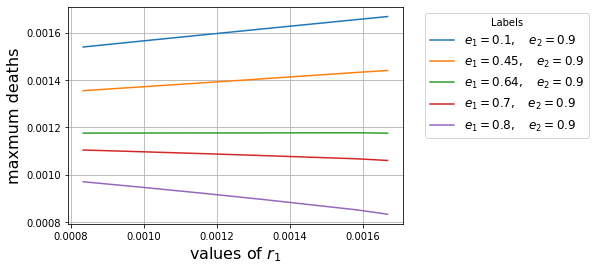

In [73]:
def Max_deaths_vs_r12(solution):
   
    max_vals = []
    
    for c in range(1,len(diff_sol_list)+1):
        max_vals2=[]
        for solu in diff_sol_list[c]:
            z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = solu.y

            cases = infected + rec2 + hosp + crit + death
            all_persons2 = [val for val in death]
            max_vals2.append(max(all_persons2))
        max_vals.append(max_vals2)

    return max_vals
#==========================================================================================================

diff_sol_list={}
for v in range(1,6):
    diff_sol_list[v]=[]
    for u in range(2,8):
        diff_sol_list[v].append(sol[u][v-1])
        
r1=[100000,95000,80000,70000,60000,50000]
r_1=[(1/600), (19/12000), (1/750), (7/6000), (1/1000), (1/1200)]
max_vals1,max_vals_2, max_vals3,  max_vals4, max_vals5 =Max_deaths_vs_r12(diff_sol_list)


M1,=plt.plot(r_1, max_vals5, label='$e_1=0.1, \quad e_2=0.9$')
M2,=plt.plot(r_1,max_vals1, label='$e_1=0.45, \quad e_2=0.9$')
M3,=plt.plot(r_1,max_vals_2, label='$e_1=0.64,\quad e_2=0.9$')
M4,=plt.plot(r_1, max_vals3, label='$e_1=0.7, \quad e_2=0.9$')
M5,=plt.plot(r_1, max_vals4, label='$e_1=0.8, \quad e_2=0.9$')
plt.plot(figuresize=(10,8))
plt.ylabel('maxmum deaths',fontsize=16)
plt.xlabel('values of $r_1$',fontsize=16)
#plt.title('Maximum deaths vs ${r_1}$')
plt.legend(handles=[M1,M2,M3,M4,M5], title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
#plt.legend(loc='best')
plt.grid(True)
plt.show()
#diff_sol_list
#diff_sol_list[v]
#sol[u][0]

## $\mathbf{r_1}$ as a function of $\mathbf{e_1}$ and fixed $\mathbf{e_2=0.9}$ 

In [52]:
arg3={}
sol3={}
for v in range(1,8):
    arg3[v]=[]
    sol3[v]=[]
    for u in range(15):
        arg3[v].append((R_0, t_inf, t_hosp, t_crit, m, k, f,list_of_r1[v-1],list_of_r2[v-1],DIFF_e1[u],DIFFe2[8]))
        sol3[v].append(solve_ivp(V0V1V2IR_HCD_model, [0, number_of_days], initial_state, args=arg3[v][u], t_eval=np.arange(number_of_days)))

In [53]:
len(DIFF_e1)

15

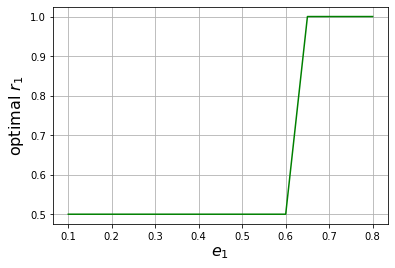

In [58]:
def eMax_deaths_vs_r12(solution):
   
    max_vals = []
    
    for c in range(1,len(diff_sol_list)+1):
        max_vals2=[]
        for solu in diff_sol_list[c]:
            z_vaccination, f_vaccination, s_vaccination, infected, rec1, rec2, hosp, crit, death = solu.y

            cases = infected + rec2 + hosp + crit + death
            all_persons2 = [val for val in death]
            max_vals2.append(max(all_persons2))
        max_vals.append(max_vals2)

    return max_vals

diff_sol_list={}
for v in range(1,16):
    diff_sol_list[v]=[]
    for u in range(2,8):
        diff_sol_list[v].append(sol3[u][v-1])
        
r1=[100000,95000,80000,70000,60000,50000]
r_1=[(1/600), (19/12000), (1/750), (7/6000), (1/1000), (1/1200)]
LIST1,LIST2,LIST3,LIST4,LIST5,LIST6,LIST7,LIST8,LIST9,LIST10,LIST11,LIST12,LIST13,LIST14,LIST15=eMax_deaths_vs_r12(diff_sol_list)
xy=[LIST1,LIST2,LIST3,LIST4,LIST5,LIST6,LIST7,LIST8,LIST9,LIST10,LIST11,LIST12,LIST13,LIST14,LIST15]
#===========================================================================================================

optimal_r1_values=[]
for i in xy:
    optimal_r1=(r_1[i.index(min(i))])*600
    optimal_r1_values.append(optimal_r1)
optimal_r1_values
#===========================================================================================================
plt.plot(DIFF_e1,optimal_r1_values,color='green')
plt.xlabel('$e_1$',fontsize=16)
plt.ylabel('optimal $r_1$',fontsize=16)
plt.grid(True)
plt.show()


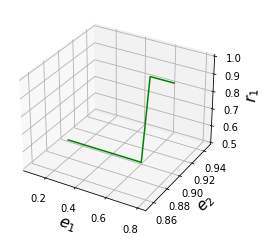

In [69]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
#X, Y = np.meshgrid(e1, e2)
E2=[0.9 for v in range(15)]
ax.plot(DIFF_e1,E2, optimal_r1_values, alpha=1,color='g')

ax.set_xlabel("$e_1$", fontsize=16)
ax.set_ylabel("$e_2$", fontsize=16)
ax.set_zlabel("$r_1$", fontsize=16)

#ax.scatter(e1[3], e2[3], r1[3,3], s=50, c='r')
plt.show()

## Changing values of $\mathbf{e_2}$ and observe changes

<Figure size 288x288 with 0 Axes>

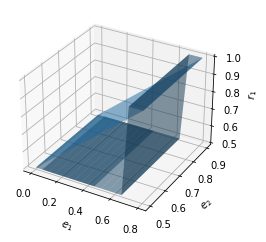

In [85]:
%matplotlib inline

#%matplotlib notebook


from mpl_toolkits.mplot3d import axes3d 

fig = plt.figure(figsize=(4,4))

#ax = fig.add_subplot(111, projection='3d')

e1=[v*.05 for v in range(1,17)]
e12=[v*0.05 for v in range(10)]
e1=e1+e12
e2=[.9 for v in range(1,17)]
e21=[0.5 for v in range(10)]
e2=e2+e21
r1=[0.5 for v in range (13)]+[1 for v in range(3)]
r11=[0.5 for v in range (10)]
r1=np.array([r1+r11])
# ax.plot(e1,e2,r1,marker='o')
# ax.set_xlabel("$e_1$", fontsize=10)
# ax.set_ylabel("$e_2$", fontsize=10)
# ax.set_zlabel("$r_1$", fontsize=10)
#Z=np.array([(Z+Z1+Z2)])
#r1=np.array(r1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y = np.meshgrid(e1, e2)
ax.plot_surface(X, Y, r1, alpha=0.5, rstride=1, cstride=1)
ax.set_xlabel("$e_1$", fontsize=10)
ax.set_ylabel("$e_2$", fontsize=10)
ax.set_zlabel("$r_1$", fontsize=10)

#ax.scatter(e1[3], e2[3], r1[3,3], s=50, c='r')
plt.show()



